In [1]:
import numpy as np
import pandas as pd
from pmagpy import pmag, ipmag
from scipy.spatial.transform import Rotation as rotation
import matplotlib.pyplot as plt

import auxiliary as aux

In [2]:
time_span = 80 # add an extra 10 or so to ensure to avoid boundary effects

echange_min = 5
echange_max = 20
omega_min = 0.2
omega_max = 1.0

pp_freq_min = 0.3
pp_freq_max = 0.5
pp_dur_min = 1
pp_dur_max = 15
pp_n_min = 5
pp_n_max = 40
pp_k_min = 20
pp_k_max = 30

site_n_min = 5
site_n_max = 10
site_k_min = 60
site_k_max = 130

ref_point = [0, 90]
slat = 35
slon = -105

In [3]:
def get_rotations():
    
    # get number of euler poles
    e_end, e_start, e_span = [], [], []
    time = 0
    while time < time_span:
        e_end.append(time)
        span = np.random.uniform(low = echange_min, high = echange_max)                     # assumes epoles change every 5-20 Myrs
        e_span.append(span)
        time = time + span
        e_start.append(time)

    # get euler poles
    epoles, omegas = [], []
    for i in range(len(e_end)):
        rand_xy = np.random.uniform(0, 0.5)
        rand_z = np.random.uniform(0, 0.5)
        epoles.append([360 * rand_xy, np.arcsin(rand_z * 2 - 1) * 180/np.pi])
        omegas.append(np.random.uniform(omega_min, omega_max))

    df_rhist = pd.DataFrame({'e_lon': [item[0] for item in epoles],
                             'e_lat': [item[1] for item in epoles],
                             'e_omega': omegas, 
                             'e_start': e_start,
                             'e_end': e_end,
                             'e_span': e_span})
    return df_rhist

In [4]:
def rotate_thru_time (df_rhist, point, age):
    
    for i, row in df_rhist.iterrows():
        if age >= row.e_end and age <= row.e_start:
            
            # get partial stage rotation within age bracket that vgp falls within
            w = np.radians((age - row.e_end) * row.e_omega)
            epole = np.array(pmag.dir2cart([row.e_lon, row.e_lat]))                
            r = rotation.from_rotvec(w * epole)
            rot_pt = r.apply(point)

            #apply all subsequent rotations
            if i != 0: 
                j = i-1
                while j != -1:
                    w = np.radians(df_rhist.iloc[j]['e_span'] * df_rhist.iloc[j]['e_omega'])
                    epole = np.array(pmag.dir2cart([df_rhist.iloc[j]['e_lon'], df_rhist.iloc[j]['e_lat']]))
                    r = rotation.from_rotvec(w * epole)
                    rot_pt = r.apply(rot_pt)
                    j-=1   
            break
    return rot_pt

In [5]:
def get_true_APWP (time_span, df_rhist, ref_point):
    
    poles = []
    ages = np.arange(0, int(time_span), 1)
    for i in ages:
        poles.append(rotate_thru_time(df_rhist, pmag.dir2cart(ref_point), i))

    APWP = [pmag.cart2dir(x[0]) for x in poles]
    t_dict = {'t_lon': [item[0] for item in APWP],
              't_lat': [item[1] for item in APWP],
              't_age': ages}

    df_true = pd.DataFrame(t_dict)
    return df_true

In [6]:
def set_study_level ():
    
    # get number of observations
    num_obs = np.random.randint(low = int(pp_freq_min * time_span), high = int(pp_freq_max * time_span))
    
    # get ages
    min_ages = np.sort(np.random.uniform(low = 0, high = int(time_span-pp_dur_max), size = num_obs))
    durations = np.random.uniform(low = int(pp_dur_min), high = int(pp_dur_max), size = num_obs)
    max_ages = min_ages + durations
    mean_ages = (max_ages + min_ages)/2
    
    # get n's and k's
    n_vals = np.random.randint(low = pp_n_min, high = pp_n_max, size = num_obs)
    k_vals = np.random.uniform(low = pp_k_min, high = pp_k_max, size = num_obs)
    
    df_poles = pd.DataFrame({'n': n_vals,
                             'k': k_vals,
                             'age_min': min_ages,
                             'age_max': max_ages,
                             'age_mean': mean_ages})
    return df_poles

In [7]:
def get_site_level (df_poles, ref_point):
    
    df_vgps = pd.DataFrame(columns = ['pole_id', 'n', 'k', 'vgp_lon', 'vgp_lat', 'age'])
    plons, plats, A95s = [], [], []

    for i, row in df_poles.iterrows():
        N = int(row.n)

        # get age for each site (n)
        age_draws = np.sort(np.random.uniform(low=row.age_min, high=row.age_max, size=N))
        k_draws = np.random.uniform(low=site_k_min, high=site_k_max, size=N)
        n_draws = np.random.randint(low=site_n_min, high=site_n_max+1, size=N)

        # get vgp for each site (by re-estimating 'true' vgp from synthetic directions)
        true_vgp_draws = ipmag.fishrot(k=row.k, n=N, dec=ref_point[0], inc=ref_point[1])
        
        cart_vgps = []
        for j in range(N):
            true_dir = pmag.vgp_di(true_vgp_draws[j][1], true_vgp_draws[j][0], slat, slon)
            est_dirs = ipmag.fishrot(k=k_draws[j], n=n_draws[j], dec=true_dir[0], inc=true_dir[1])
            est_decs, est_incs, est_ints = ipmag.unpack_di_block(est_dirs)
            est_mean = ipmag.fisher_mean(est_decs, est_incs)
            est_vgp = pmag.dia_vgp(est_mean['dec'], est_mean['inc'], 0, slat, slon)
            cart_vgps.append(pmag.dir2cart([est_vgp[0], est_vgp[1]]))

        # determine and apply rotation history for each vgp
        pole_ids, vgps = [], []
        for k in range(N):
            rot_vgp = rotate_thru_time(df_rhist, cart_vgps[k], age_draws[k])
            vgps.append(pmag.cart2dir(rot_vgp[0]))
            pole_ids.append(i)

        # compute mean paleopole for each 'study'
        vgp_lons = [x[0] for x in vgps]
        vgp_lats = [x[1] for x in vgps]
        mean = ipmag.fisher_mean(dec=vgp_lons, inc=vgp_lats)
        plons.append(mean['dec'])
        plats.append(mean['inc'])
        A95s.append(mean['alpha95'])

        # pass vgps to a separate dataframe
        vgp_dict = {'pole_id': pole_ids,
                    'n': n_draws,
                    'k': k_draws,
                    'vgp_lon': vgp_lons,
                    'vgp_lat': vgp_lats,
                    'age': age_draws}

        df_update = pd.DataFrame(vgp_dict)
        df_vgps = df_vgps.append(df_update, ignore_index=True)

    df_poles['plon'] = plons
    df_poles['plat'] = plats
    df_poles['A95'] = A95s
    
    return df_poles, df_vgps

In [8]:
def running_mean (df, lon, lat, age, window_length, time_step, start_time, end_time):
    
    mean_pole_ages = np.arange(end_time, start_time + time_step, time_step)
    
    df_running_means = pd.DataFrame(columns=['N', 'plon', 'plat', 'A95', 'age'])
    
    for i in mean_pole_ages:
        window_min = i - (window_length / 2.)
        window_max = i + (window_length / 2.)
        poles = df.loc[(df[age] >= window_min) & (df[age] <= window_max)]
        if len(poles) > 1:
            mean = ipmag.fisher_mean(dec=poles[lon].tolist(), inc=poles[lat].tolist())
            df_running_means.loc[i] = [mean['n'], mean['dec'], mean['inc'], mean['alpha95'], i]
        elif len(poles) == 1:
            df_running_means.loc[i] = [1, float(poles[lon]), float(poles[lat]), 0, i]
    
    df_running_means.reset_index(drop=1, inplace=True)
    
    return df_running_means

In [9]:
def get_pseudo_vgps (df_poles):  #column labels are presently hard-coded into this, if relevant.

    pole_ids, age_draws, vgp_lons, vgp_lats = ([] for i in range(4))
    for i, row in df_poles.iterrows():
        n = int(row.n)
        
        # grab new ages
        age_draws.append(np.sort(np.random.uniform(low=row.age_min, high=row.age_max, size=n)))
        
        # grab new vgps
        pvgps = ipmag.fishrot(k=row.k, n=n, dec=row.plon, inc=row.plat, di_block=False)
        vgp_lons.append(pvgps[0])
        vgp_lats.append(pvgps[1])
            
        pole_ids.append([i for _ in range(n)])

    pseudo_data = {'pole_id': [item for sublist in pole_ids for item in sublist],
                   'vgp_lat': [item for sublist in vgp_lats for item in sublist],
                   'vgp_lon': [item for sublist in vgp_lons for item in sublist],
                   'age':  [item for sublist in age_draws for item in sublist]}
    
    df_pseudo_vgps = pd.DataFrame(pseudo_data)
    
    return df_pseudo_vgps

In [10]:
def bootstrap_vgps (df_vgps):
    
    vgp_lons, vgp_lats = [], []
    for i, row in df_vgps.iterrows():
        
        # re-estimate vgps from n, k and vgp
        true_dir = pmag.vgp_di(row.vgp_lat, row.vgp_lon, slat, slon)
        est_dirs = ipmag.fishrot(k=row.k, n=row.n, dec=true_dir[0], inc=true_dir[1])
        est_decs, est_incs, est_ints = ipmag.unpack_di_block(est_dirs)
        est_mean = ipmag.fisher_mean(est_decs, est_incs)
        est_vgp = pmag.dia_vgp(est_mean['dec'], est_mean['inc'], 0, slat, slon)
        vgp_lons.append(est_vgp[0])
        vgp_lats.append(est_vgp[1])
        
    booted_vgps = {'vgp_lat': vgp_lats,
                   'vgp_lon': vgp_lons,
                   'age':  df_vgps.age}
    
    df_booted_vgps = pd.DataFrame(booted_vgps)
    
    return df_booted_vgps

In [11]:
def compare_means (df1, lon1, lat1, age1, df2, lon2, lat2, age2):
    
    df_compare = df1[df1[age1].isin(df2[age2])]
    df_compare['lon2'] = df2[lon2].values
    df_compare['lat2'] = df2[lat2].values
    df_compare['gcd'] = df_compare.apply(lambda row: np.float(pmag.angle([row[lon1], row[lat1]], [row['lon2'], row['lat2']])), axis=1)
    
    df_compare.reset_index(drop=1, inplace=True)
    return df_compare['gcd']

In [12]:
# setup APWP parameters
start_time = time_span
end_time = 0
window_length = 10
time_step = 1

df_pole_results = pd.DataFrame(columns=['N', 'age', 'gcd'])
df_para_results = pd.DataFrame(columns=['N', 'age', 'gcd'])
df_nonpara_results = pd.DataFrame(columns=['N', 'age', 'gcd'])
#df_vgps_results = pd.DataFrame(columns=['N', 'age', 'gcd'])

for i in range(100):
    print (i)
    
    # get rotation histoy
    df_rhist = get_rotations()
        
    # compute true APWP
    df_true = get_true_APWP (time_span, df_rhist, ref_point)
    
    # set study-level parameters
    df_poles = set_study_level()
    
    # get site-level 'observations' and calculate paleopoles
    df_poles, df_vgps = get_site_level(df_poles, ref_point)
    
    # calculate running mean for deterministic poles
    df_poles_APWP = running_mean(df_poles, 'plon', 'plat', 'age_mean', window_length, time_step, start_time, end_time)
    df_poles_APWP['gcd'] = compare_means(df_true, 't_lon', 't_lat', 't_age', df_poles_APWP, 'plon', 'plat', 'age')
    df_pole_results = df_pole_results.append(df_poles_APWP, ignore_index=True)
    
    """
    # calculate running mean for parametrically-resampled poles
    df_para_runs = pd.DataFrame(columns=['N', 'plon', 'plat', 'A95', 'age'])
    for j in range(100):
        df_pseudo_vgps = get_pseudo_vgps(df_poles)
        df_pseudo_APWP = running_mean(df_pseudo_vgps, 'vgp_lon', 'vgp_lat', 'age', window_length, time_step, start_time, end_time)
        df_para_runs = df_para_runs.append(df_pseudo_APWP, ignore_index=True)

    df_para_APWP = pd.DataFrame()
    age_groups = df_para_runs.groupby(['age']) 
    for age, group in age_groups:
        mean = ipmag.fisher_mean(dec = group['plon'].tolist(), inc = group['plat'].tolist()) # compute mean vgp from among time_units
        df_para_APWP = df_para_APWP.append({'N': mean['n'], 'plon': mean['dec'], 'plat': mean['inc'], 'A95': mean['alpha95'], 'age': age}, ignore_index=True)
        
    df_para_APWP = df_para_APWP[df_para_APWP.age < time_span]    # ignore any ages that exceed time_span
    df_para_APWP['gcd'] = compare_means(df_true, 't_lon', 't_lat', 't_age', df_para_APWP, 'plon', 'plat', 'age')
    df_para_results = df_para_results.append(df_para_APWP, ignore_index=True)
    """
        
    # calculate running mean with vgp-based approach
    df_nonpara_runs = pd.DataFrame(columns=['N', 'plon', 'plat', 'A95', 'age'])
    for j in range(100):
        df_bootstrap_vgps = bootstrap_vgps(df_vgps)
        df_bootstrap_APWP = running_mean(df_bootstrap_vgps, 'vgp_lon', 'vgp_lat', 'age', window_length, time_step, start_time, end_time)
        df_nonpara_runs = df_nonpara_runs.append(df_bootstrap_APWP, ignore_index=True)
    
    df_nonpara_APWP = pd.DataFrame()
    age_groups = df_nonpara_runs.groupby(['age']) 
    for age, group in age_groups:
        mean = ipmag.fisher_mean(dec = group['plon'].tolist(), inc = group['plat'].tolist()) # compute mean vgp from among time_units
        df_nonpara_APWP = df_nonpara_APWP.append({'N': mean['n'], 'plon': mean['dec'], 'plat': mean['inc'], 'A95': mean['alpha95'], 'age': age}, ignore_index=True)
        
    df_nonpara_APWP = df_nonpara_APWP[df_nonpara_APWP.age < time_span]    # ignore any ages that exceed time_span
    df_nonpara_APWP['gcd'] = compare_means(df_true, 't_lon', 't_lat', 't_age', df_nonpara_APWP, 'plon', 'plat', 'age')
    df_nonpara_results = df_nonpara_results.append(df_nonpara_APWP, ignore_index=True)
    
    #df_vgps_APWP = running_mean(df_vgps, 'vgp_lon', 'vgp_lat', 'age', window_length, time_step, start_time, end_time)
    #df_vgps_APWP = df_vgps_APWP[df_vgps_APWP.age < time_span]   # ignore any ages that exceed time_span
    #df_vgps_APWP['gcd'] = compare_means(df_true, 't_lon', 't_lat', 't_age', df_vgps_APWP, 'plon', 'plat', 'age')
    #df_vgps_results = df_vgps_results.append(df_vgps_APWP, ignore_index=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


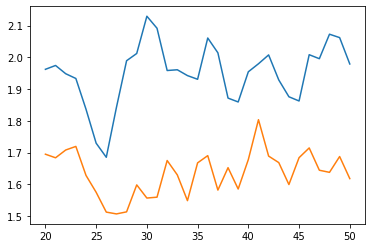

In [13]:
# remove results with possible boundary effects
df_pole_results = df_pole_results[(df_pole_results.age >= 0 + 2 * window_length) & (df_pole_results.age <= time_span - 3 * window_length)]
#df_para_results = df_para_results[(df_para_results.age >= 0 + window_length) & (df_para_results.age <= time_span - 2 * window_length)]
#df_vgps_results = df_vgps_results[(df_vgps_results.age >= 0 + 2 * window_length) & (df_vgps_results.age <= time_span - 3 * window_length)]
df_nonpara_results = df_nonpara_results[(df_nonpara_results.age >= 0 + 2 * window_length) & (df_nonpara_results.age <= time_span - 3 * window_length)]

# plot summary results
plt.plot(df_pole_results.groupby('age')['gcd'].mean())
#plt.plot(df_para_results.groupby('age')['gcd'].mean())
plt.plot(df_nonpara_results.groupby('age')['gcd'].mean())
#plt.plot(df_vgps_results.groupby('age')['gcd'].mean())

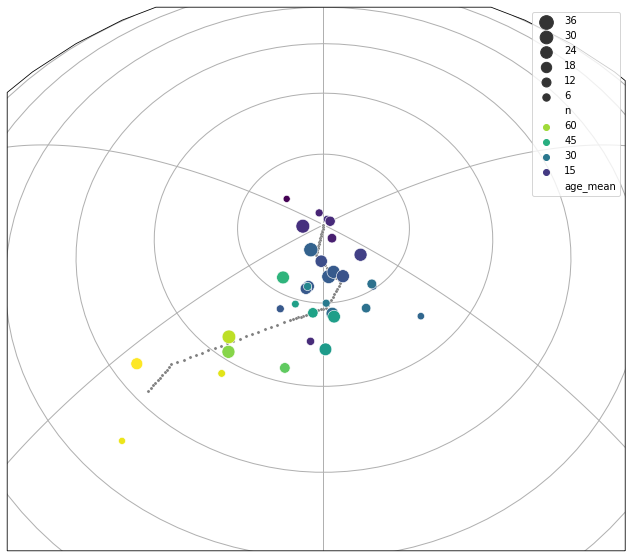

In [18]:
#aux.plot_poles(df_nonpara_APWP, 'plon', 'plat', 'A95', 'age', 'N', [0, 60], df_true, 't_lon', 't_lat', plot_A95s=False, connect_poles=True, plot_true=True)
aux.plot_poles(df_poles, 'plon', 'plat', None, 'age_mean', 'n', [0, 60], df_true, 't_lon', 't_lat', plot_A95s=False, connect_poles=False, plot_true=True)

In [15]:
see = df_pole_results.tail(50)
see

,N,age,gcd,plon,plat,A95
7031,4.0,32.0,1.148670,270.017422,70.906975,2.282092
7032,4.0,33.0,1.360617,268.959190,70.126759,2.244838
7033,3.0,34.0,2.146133,267.757997,70.053956,3.348609
7034,4.0,35.0,1.814294,268.203690,69.625811,2.283793
7035,4.0,36.0,1.880826,268.203690,69.625811,2.283793
7036,4.0,37.0,1.947358,268.203690,69.625811,2.283793
7037,5.0,38.0,2.134474,266.677882,69.137601,2.826488
7038,4.0,39.0,2.025241,267.277266,69.162448,3.869060
7039,4.0,40.0,2.089114,267.277266,69.162448,3.869060
7040,6.0,41.0,1.012872,270.378418,68.707344,3.079919
